In [1]:
!pip install segmentation-models-pytorch

     |████████████████████████████████| 88 kB 113 kB/s eta 0:00:01
     |████████████████████████████████| 376 kB 80 kB/s eta 0:00:01
     |████████████████████████████████| 58 kB 57 kB/s eta 0:00:011
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=d919a27bc556aff6ba0dfbf31808391cb97ee6c1c08e7d7af1ccd8b16f27b18c
  Stored in directory: /home/jun/.cache/pip/wheels/6b/48/d7/9a3ea4072e0d735f895d5e58f9a679903dcb4e90a55418955b
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=e08913dd62c17d0d814bc1deb1b46008d2fbb41305c3e8296211d75fe0e3aa11
  Stored in directory: /home/jun/.cache/pip/wheels/ed/fa/b9/5c82b59d905f95542a192b883c0cc0082407ea2f54beb2f9e6
Successfully built efficientnet-pytorch pretrainedmodels


In [3]:
import torch.nn as nn
from  torch.utils.data import Dataset,DataLoader
import torch
import torchvision
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.collections import QuadMesh
import seaborn as sns
from tqdm import tqdm,trange
from time import sleep
import warnings
from glob import glob
import os,sys
import cv2
import segmentation_models_pytorch as smp
# sys.path.append('/home/jun/Github/ML-Learning/Resourses')
# from pretty_confusion_matrix import pretty_plot_confusion_matrix
warnings.filterwarnings("ignore")
BASEPATH = '/home/jun/Data/Depth-Kaggle/data'

In [4]:
# -*- coding: utf-8 -*-
"""
plot a pretty confusion matrix with seaborn
Created on Mon Jun 25 14:17:37 2018
@author: Wagner Cipriano - wagnerbhbr - gmail - CEFETMG / MMC
REFerences:
  https://www.mathworks.com/help/nnet/ref/plotconfusion.html
  https://stackoverflow.com/questions/28200786/how-to-plot-scikit-learn-classification-report
  https://stackoverflow.com/questions/5821125/how-to-plot-confusion-matrix-with-string-axis-rather-than-integer-in-python
  https://www.programcreek.com/python/example/96197/seaborn.heatmap
  https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels/31720054
  http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
"""

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
from matplotlib.collections import QuadMesh


def get_new_fig(fn, figsize=[9, 9]):
    """Init graphics"""
    fig1 = plt.figure(fn, figsize)
    ax1 = fig1.gca()  # Get Current Axis
    ax1.cla()  # clear existing plot
    return fig1, ax1


def configcell_text_and_colors(
    array_df, lin, col, oText, facecolors, posi, fz, fmt, show_null_values=0
):
    """
    config cell text and colors
    and return text elements to add and to dell
    @TODO: use fmt
    """
    text_add = []
    text_del = []
    cell_val = array_df[lin][col]
    tot_all = array_df[-1][-1]
    per = (float(cell_val) / tot_all) * 100
    curr_column = array_df[:, col]
    ccl = len(curr_column)

    # last line  and/or last column
    if (col == (ccl - 1)) or (lin == (ccl - 1)):
        # tots and percents
        if cell_val != 0:
            if (col == ccl - 1) and (lin == ccl - 1):
                tot_rig = 0
                for i in range(array_df.shape[0] - 1):
                    tot_rig += array_df[i][i]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif col == ccl - 1:
                tot_rig = array_df[lin][lin]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif lin == ccl - 1:
                tot_rig = array_df[col][col]
                per_ok = (float(tot_rig) / cell_val) * 100
            per_err = 100 - per_ok
        else:
            per_ok = per_err = 0

        per_ok_s = ["%.2f%%" % (per_ok), "100%"][per_ok == 100]

        # text to DEL
        text_del.append(oText)

        # text to ADD
        font_prop = fm.FontProperties(weight="bold", size=fz)
        text_kwargs = dict(
            color="w",
            ha="center",
            va="center",
            gid="sum",
            fontproperties=font_prop,
        )
        lis_txt = ["%d" % (cell_val), per_ok_s, "%.2f%%" % (per_err)]
        lis_kwa = [text_kwargs]
        dic = text_kwargs.copy()
        dic["color"] = "g"
        lis_kwa.append(dic)
        dic = text_kwargs.copy()
        dic["color"] = "r"
        lis_kwa.append(dic)
        lis_pos = [
            (oText._x, oText._y - 0.3),
            (oText._x, oText._y),
            (oText._x, oText._y + 0.3),
        ]
        for i in range(len(lis_txt)):
            newText = dict(
                x=lis_pos[i][0],
                y=lis_pos[i][1],
                text=lis_txt[i],
                kw=lis_kwa[i],
            )
            text_add.append(newText)

        # set background color for sum cells (last line and last column)
        carr = [0.27, 0.30, 0.27, 1.0]
        if (col == ccl - 1) and (lin == ccl - 1):
            carr = [0.17, 0.20, 0.17, 1.0]
        facecolors[posi] = carr

    else:
        if per > 0:
            txt = "%s\n%.2f%%" % (cell_val, per)
        else:
            if show_null_values == 0:
                txt = ""
            elif show_null_values == 1:
                txt = "0"
            else:
                txt = "0\n0.0%"
        oText.set_text(txt)

        # main diagonal
        if col == lin:
            # set color of the textin the diagonal to white
            oText.set_color("w")
            # set background color in the diagonal to blue
            facecolors[posi] = [0.35, 0.8, 0.55, 1.0]
        else:
            oText.set_color("r")

    return text_add, text_del


def insert_totals(df_cm):
    """insert total column and line (the last ones)"""
    sum_col = []
    for c in df_cm.columns:
        sum_col.append(df_cm[c].sum())
    sum_lin = []
    for item_line in df_cm.iterrows():
        sum_lin.append(item_line[1].sum())
    df_cm["sum_lin"] = sum_lin
    sum_col.append(np.sum(sum_lin))
    df_cm.loc["sum_col"] = sum_col


def pp_matrix(
    df_cm,
    annot=True,
    cmap="Oranges",
    fmt=".2f",
    fz=11,
    lw=0.5,
    cbar=False,
    figsize=[8, 8],
    show_null_values=0,
    pred_val_axis="y",
):
    """
    print conf matrix with default layout (like matlab)
    params:
      df_cm          dataframe (pandas) without totals
      annot          print text in each cell
      cmap           Oranges,Oranges_r,YlGnBu,Blues,RdBu, ... see:
      fz             fontsize
      lw             linewidth
      pred_val_axis  where to show the prediction values (x or y axis)
                      'col' or 'x': show predicted values in columns (x axis) instead lines
                      'lin' or 'y': show predicted values in lines   (y axis)
    """
    if pred_val_axis in ("col", "x"):
        xlbl = "Predicted"
        ylbl = "Actual"
    else:
        xlbl = "Actual"
        ylbl = "Predicted"
        df_cm = df_cm.T

    # create "Total" column
    insert_totals(df_cm)

    # this is for print allways in the same window
    fig, ax1 = get_new_fig("Conf matrix default", figsize)

    ax = sn.heatmap(
        df_cm,
        annot=annot,
        annot_kws={"size": fz},
        linewidths=lw,
        ax=ax1,
        cbar=cbar,
        cmap=cmap,
        linecolor="w",
        fmt=fmt,
    )

    # set ticklabels rotation
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=10)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=25, fontsize=10)

    # Turn off all the ticks
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # face colors list
    quadmesh = ax.findobj(QuadMesh)[0]
    facecolors = quadmesh.get_facecolors()

    # iter in text elements
    array_df = np.array(df_cm.to_records(index=False).tolist())
    text_add = []
    text_del = []
    posi = -1  # from left to right, bottom to top.
    for t in ax.collections[0].axes.texts:  # ax.texts:
        pos = np.array(t.get_position()) - [0.5, 0.5]
        lin = int(pos[1])
        col = int(pos[0])
        posi += 1

        # set text
        txt_res = configcell_text_and_colors(
            array_df, lin, col, t, facecolors, posi, fz, fmt, show_null_values
        )

        text_add.extend(txt_res[0])
        text_del.extend(txt_res[1])

    # remove the old ones
    for item in text_del:
        item.remove()
    # append the new ones
    for item in text_add:
        ax.text(item["x"], item["y"], item["text"], **item["kw"])

    # titles and legends
    ax.set_title("Confusion matrix")
    ax.set_xlabel(xlbl)
    ax.set_ylabel(ylbl)
    plt.tight_layout()  # set layout slim
    plt.show()


def pp_matrix_from_data(
    y_test,
    predictions,
    columns=None,
    annot=True,
    cmap="Oranges",
    fmt=".2f",
    fz=11,
    lw=0.5,
    cbar=False,
    figsize=[8, 8],
    show_null_values=0,
    pred_val_axis="lin",
):
    """
    plot confusion matrix function with y_test (actual values) and predictions (predic),
    whitout a confusion matrix yet
    """
    from pandas import DataFrame
    from sklearn.metrics import confusion_matrix

    # data
    if not columns:
        from string import ascii_uppercase

        columns = [
            "class %s" % (i)
            for i in list(ascii_uppercase)[0 : len(np.unique(y_test))]
        ]

    confm = confusion_matrix(y_test, predictions)
    fz = 11
    figsize = [9, 9]
    show_null_values = 2
    df_cm = DataFrame(confm, index=columns, columns=columns)
    pp_matrix(
        df_cm,
        fz=fz,
        cmap=cmap,
        figsize=figsize,
        show_null_values=show_null_values,
        pred_val_axis=pred_val_axis,
    )

In [5]:
def read_csv(path):
    df=pd.read_csv(path,names=['image','label'],header=None)
    return df
def read_image(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

df = read_csv(os.path.join(BASEPATH,'nyu2_train.csv'))
df['image'] = df['image'].apply(lambda x: '/home/jun/Data/Depth-Kaggle/'+x)
df['label'] = df['label'].apply(lambda x: '/home/jun/Data/Depth-Kaggle/'+x)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50688 entries, 0 to 50687
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   50688 non-null  object
 1   label   50688 non-null  object
dtypes: object(2)
memory usage: 792.1+ KB


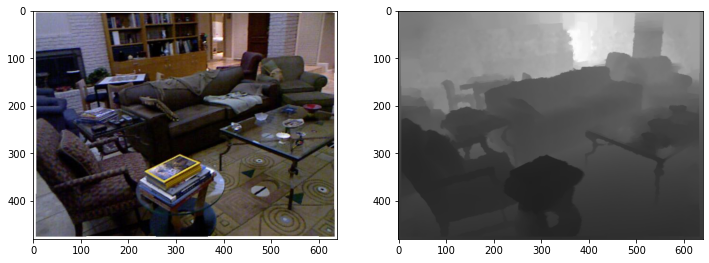

In [6]:
fig,axis = plt.subplots(1,2,figsize=(12,6))
axis[0].imshow(read_image(df.iloc[0].image))
axis[1].imshow(read_image(df.iloc[0].label))
plt.show()

In [7]:
class CFG():
    def __init__(self):
        self.lr = 3e-4
        self.epoch=15
        self.TTA_times=0
        self.batch_size = 32
        self.image_size = (192,256)
        self.seed=31
        self.fold = 5
        self.run_fold=1
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        print(self.device)


def setSeed(seed=31,tor=True,tensorf=False):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)#only one time
    pd.core.common.random_state(seed)
    # tensorflow seed setting
    if tensorf:
        tf.random.set_seed(seed)
        session_conf = tf.compat.v1.ConfigProto(
            intra_op_parallelism_threads=1,
            inter_op_parallelism_threads=1
        )
        sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
        tf.compat.v1.keras.backend.set_session(sess)
        
    # pytorch seed setting
    if tor:
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        
        
        
cfg = CFG()
setSeed(cfg.seed)

cuda:0


In [8]:
class Logger():
    logger_dict={}
    logger_raw_dict={}
    log_category=None
    
    def __init__(self,name,layer=0):
        self.history=pd.DataFrame()
        self.epoch_history=pd.DataFrame()
        self.current_epoch_history=pd.DataFrame()
        self.name=name
        self.epoch=0
        self.layer=str(layer)
        if self.layer not in Logger.logger_dict.keys():
            Logger.logger_dict[self.layer] = {}
            Logger.logger_raw_dict[self.layer] = {}
            
    def __call__(self,**kwargs):
        new_row = pd.DataFrame(kwargs,index=[0])
        self.current_epoch_history=self.current_epoch_history.append(new_row)
    
    def __str__(self,r=3):
        output_str=''
        if len(self.current_epoch_history)>0:
            avg_epoch = self.get_current_epoch_avg()
            for log_c in avg_epoch.index:
                output_str+= 'avg{}:{} \t'.format(log_c,f'%.{r}f'%avg_epoch[log_c])
            return output_str
        else:
            avg_epoch = self.epoch_history.iloc[-1]
            for log_c in avg_epoch.index:
                output_str+= 'avg{}:{} \t'.format(log_c,f'%.{r}f'%avg_epoch[log_c])
            return output_str
        
    def get_current_epoch_avg(self):
        return self.current_epoch_history.mean()
    
    def get_best_record(self,category='loss',mode='min',unit='epoch'):
        _history = self.epoch_history if unit == 'epoch' else self.history
        if mode == 'min':
            best_index = _history[category].idxmin()
        else:
            best_index = _history[category].idxmax()
        return best_index, _history.iloc[best_index]

    def check_best(self,category='loss',mode='min',unit='epoch'):
        _history = self.epoch_history if unit == 'epoch' else self.history
        best_index,best_record = self.get_best_record(category,mode,unit)
        return (len(_history[category])-1)==best_index

    def save_epoch(self):
        if Logger.log_category==None:
            Logger.log_category = self.current_epoch_history.columns.to_list()
        self.epoch_history=self.epoch_history.append(self.get_current_epoch_avg().copy(),ignore_index=True).reset_index(drop=True)
        self.current_epoch_history['epoch'] = self.epoch
        self.epoch += 1
        self.history = self.history.append(self.current_epoch_history.copy()).reset_index(drop=True)
        self.current_epoch_history=pd.DataFrame(columns=Logger.log_category)
        Logger.logger_dict[self.layer][self.name]=self.history
        
        
    @staticmethod
    def plot(unit='epoch',show_category=None,figsize=(6.2,3)):
        
        show_category=Logger.log_category if show_category == None else show_category
        layer_list = sorted(list(Logger.logger_dict.keys()))
        figers, axs = plt.subplots(len(layer_list),len(show_category),figsize=(len(show_category)*figsize[0],len(layer_list)*figsize[1]))
        plt.subplots_adjust(hspace=0.5)

        if len(layer_list)>1 and len(show_category)>1:
            for lidx,l in enumerate(layer_list):
                keys_list=list(Logger.logger_dict[l].keys())
                for kidx,k in enumerate(keys_list):
                    for lcidx,log_c in enumerate(show_category):
                        _history=Logger.logger_dict[l][k]
                        _history = _history.groupby('epoch').mean() if unit == 'epoch' else _history
                        sns.lineplot(data=_history,x=range(len(_history)),y=log_c,ax=axs[lidx,lcidx],label=k).set(title = '{}'.format(log_c))
                        axs[lidx,lcidx].legend(loc='upper left')

        elif len(layer_list)>1:
            for lidx,l in enumerate(layer_list):
                keys_list=list(Logger.logger_dict[l].keys())
                for kidx,k in enumerate(keys_list):
                    for lcidx,log_c in enumerate(show_category):
                        _history=Logger.logger_dict[l][k]
                        _history = _history.groupby('epoch').mean() if unit == 'epoch' else _history
                        sns.lineplot(data=_history,x=range(len(_history)),y=log_c,ax=axs[lidx],label=k).set(title = '{}'.format(log_c))
                        axs[lidx].legend(loc='upper left')
        elif len(show_category)>1:
            for lidx,l in enumerate(layer_list):
                keys_list=list(Logger.logger_dict[l].keys())
                for kidx,k in enumerate(keys_list):
                    for lcidx,log_c in enumerate(show_category):
                        _history=Logger.logger_dict[l][k]
                        _history = _history.groupby('epoch').mean() if unit == 'epoch' else _history
                        sns.lineplot(data=_history,x=range(len(_history)),y=log_c,ax=axs[lcidx],label=k).set(title = '{}'.format(log_c))
                        axs[lcidx].legend(loc='upper left')
        else:
            keys_list=list(Logger.logger_dict[layer_list[0]].keys())
            for kidx,k in enumerate(keys_list):
                for lidx,log_c in enumerate(show_category):
                    _history=Logger.logger_dict[layer_list[0]][k]
                    _history = _history.groupby('epoch').mean() if unit == 'epoch' else _history
                    sns.lineplot(data=_history,x=range(len(_history)),y=log_c,ax=axs,label=k).set(title = '{}'.format(log_c))
                    axs.legend(loc='upper left')
        plt.show()

In [9]:
def split_train_valid(_df):
    num_sample = len(_df)
    num_split = int(num_sample*cfg.training_split)
    _df = df.sample(frac=1,random_state = cfg.seed).reset_index(drop=True)
    train_df = _df.iloc[:num_split]
    valid_df = _df.iloc[num_split:]
    return train_df, valid_df

sample_df = df.sample(n=24800,random_state=1331)
df=sample_df.reset_index(drop=True)
skf = StratifiedKFold(n_splits=cfg.fold, random_state=cfg.seed, shuffle=True)
splitlist = list(skf.split(df.index,[0]*len(df.index)))

In [10]:
class NYU2_Dataset(Dataset):
    '''
    主要是把dataframe全轉成numpy來處理
    '''
    def __init__(self,df, transform=None,test=False):
        self.df =  df
        self.transform = transform
        self.test = test
        self.data_id = self.df.index
        self.labels = self.df.label.values
        self.data = self.df.image.values
        self.label_transform =  A.Compose([
                                 A.Resize(cfg.image_size[0],cfg.image_size[1],always_apply=True),
                                ])
    def get_image_pair(self,idx):
        source_image = cv2.imread(self.data[idx])
        source_image = cv2.cvtColor(source_image, cv2.COLOR_BGR2RGB)
        label_image = cv2.imread(self.labels[idx])
        label_image = cv2.cvtColor(label_image, cv2.COLOR_BGR2GRAY)
        return source_image,label_image
        
    def __getitem__(self,idx):
        data_id = self.data_id[idx]
        source_image,label_image = self.get_image_pair(idx)
        
        if self.transform:
            source_image = self.transform(image=source_image)['image']
            label_image = self.label_transform(image=label_image)['image']
            label_image = label_image/255
            label_image = torch.from_numpy(np.transpose(label_image[...,None],(2,0,1))).float()

        return data_id,source_image,label_image
    
    def __len__(self):
        return len(self.data)
    
    def _working_test(self):
        _test_dataloader = DataLoader(self,
                                      batch_size=1,
                                      shuffle=False,
                                      num_workers=1,
                                      drop_last=True,
                                      pin_memory=True)
        return next(iter(_test_dataloader))
#_test_dataset = NYU2_Dataset(df)
#data_id,data,label=_test_dataset._working_test()
#fig,axis = plt.subplots(1,2,figsize=(12,6))
#axis[0].imshow(data[0,...])
#axis[1].imshow(label[0,...])
#plt.show()

In [11]:
def get_transform():
    transform = A.Compose([
                                 A.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5]),
                                 A.Resize(cfg.image_size[0],cfg.image_size[1],always_apply=True),
                                 ToTensorV2()
                                ])
    return transform


def get_dataloader(train_df,valid_df):
    
    print('training data are processing..')
    train_dataset = NYU2_Dataset(train_df,transform=transform)
    train_dataloader = DataLoader(train_dataset,
                                  batch_size=cfg.batch_size,
                                  shuffle=True,
                                  num_workers=4,
                                  drop_last=True,
                                  pin_memory=True)
        
    print('validation data are processing..')
    valid_dataset = NYU2_Dataset(valid_df,transform=transform)
    valid_dataloader = DataLoader(valid_dataset,
                                  batch_size=cfg.batch_size,
                                  shuffle=False,
                                  num_workers=4,
                                  drop_last=False,
                                  pin_memory=True)
    
    return train_dataloader,valid_dataloader
transform = get_transform()

In [18]:
class ModelInstance():
    def __init__(self,model,optimizer,loss_function,scheduler=None,clip_grad=None):
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.certification = loss_function
        self.clip_grad = clip_grad
        
    def run_model(self,feature,label,update=True):
        feature = feature.to(cfg.device)
        label = label.to(cfg.device)
        
        if update:
            pred = self.model(feature)
        else:
            with torch.no_grad():
                pred = self.model(feature)
            
            
        loss = self.certification(pred,label)
        
        if update:
            loss.backward()
            if self.clip_grad:
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=clip_grad)
            self.optimizer.step()
            self.optimizer.zero_grad()
            
        return  pred.cpu().detach(), loss.cpu().detach().item()
    
    def predict(self,feature):
        feature = feature.to(cfg.device)
        pred = self.model(feature)
        return pred.cpu().detach()
    
def create_model_instance():
    
    def certification(predict,label):
        loss = nn.MSELoss()(predict,label)
        return loss
    
    model = smp.UnetPlusPlus(
                    encoder_name="resnet50",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
                    encoder_weights=None,#'imagenet',     # use `imagenet` pre-trained weights for encoder initialization
                    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
                    classes=1,                      # model output channels (number of classes in your dataset)
                    activation='sigmoid',
    ).to(cfg.device)
    
    model.load_state_dict(torch.load('/home/jun/Data/Depth-Kaggle/best_model.pkl'))
    
    optimizer = torch.optim.Adam(model.parameters(),lr=cfg.lr,amsgrad=True)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min', factor=0.4, patience=2, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=1e-7, eps=1e-08, verbose=True)
    return ModelInstance(model,optimizer,certification,scheduler,None)

In [19]:
from sklearn.metrics import f1_score, precision_recall_fscore_support, accuracy_score

def onehot_encoding(pred):
    return pred.argmax(dim=1)

def unnormalize(images):
        return (0.5*np.array(images)+0.5)*255
def run_epoch(dataloader,epoch,logger,validmode):
    
    if validmode:
        instance.model.eval()
    else:
        instance.model.train()
        
    trange = tqdm(enumerate(dataloader),total=len(dataloader), desc='Valid' if validmode else 'Train')
    data_id,pred=None,None
    for idx, (data_id,feature,label) in trange:
        pred,loss = instance.run_model(feature,label,not validmode)
        logger(loss=loss)
        avg_log = logger.get_current_epoch_avg()
        trange.set_postfix(loss = avg_log['loss'])
    logger.save_epoch()
    data_id = np.array(data_id)
    pred[0] = pred[0]*255
    fig,axis = plt.subplots(1,3,figsize=(12,4))
    axis[0].imshow(read_image(df.iloc[data_id[0]].image))
    axis[1].imshow(read_image(df.iloc[data_id[0]].label))
    axis[2].imshow(np.transpose(pred[0],(1,2,0)),cmap='gray')
    plt.show()
    

def inference(dataloader,test=False):
    
    instance.model.eval()
    
    all_pred=[]
    all_label=[]
    all_id=[]
    
    trange = tqdm(enumerate(dataloader),total=len(dataloader), desc='')
    if test:
        for idx, (data_id,feature) in trange:
            pred = instance.predict(feature)
            all_pred.append(pred)
            all_id.append(data_id)

        all_pred = np.concatenate(all_pred,axis=0)
        all_id = np.concatenate(all_id,axis=0)
        return all_id,all_pred
    
    else:
        for idx, (data_id,feature,label) in trange:
            pred,loss = instance.run_model(feature,label,update=False)
            all_pred.append(pred)
            all_label.append(label)
            all_id.append(data_id)

        all_pred = np.concatenate(all_pred,axis=0)
        all_label = np.concatenate(all_label,axis=0)
        all_id = np.concatenate(all_id,axis=0)
        return data_id,all_pred,all_label

In [20]:
import torch
torch.cuda.empty_cache()

In [21]:
for fold,(train_index,valid_index) in enumerate(splitlist):
    instance = create_model_instance()
    training_logger=Logger('Training',fold)
    validation_logger=Logger('Validation',fold)
    
    print('------------ Flod {} ------------'.format(fold))
    train_df = df.iloc[train_index].copy()
    valid_df = df.iloc[valid_index].copy()
    train_dataloader,valid_dataloader =get_dataloader(train_df.cuda(),valid_df.cuda())

    for epoch in range(cfg.epoch):
        print('Epoch {}/{}:'.format(epoch,cfg.epoch))
        run_epoch(train_dataloader,epoch,training_logger,False)
        run_epoch(valid_dataloader,epoch,validation_logger,True)
        if instance.scheduler:
            instance.scheduler.step(validation_logger.history.iloc[-1]['loss'])
        if validation_logger.check_best(category='loss',mode='min'):
            print('--save mode--')
            torch.save(instance.model.state_dict(),'best_model.pkl')
    display(validation_logger.get_best_record(category='loss',mode='min'))
    if cfg.run_fold == fold+1:
        break

RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 7.92 GiB total capacity; 6.73 GiB already allocated; 23.62 MiB free; 6.76 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

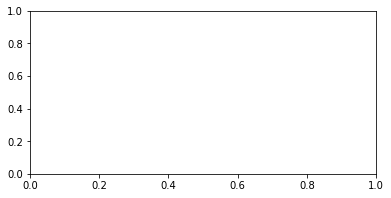

In [22]:
Logger.plot(show_category=['loss'])